In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

std_transforms = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

std_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=std_transforms)
trainloader = torch.utils.data.DataLoader(std_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=std_transforms)
validloader = torch.utils.data.DataLoader(validset, batch_size=20,
                                         shuffle=False, num_workers=2)

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# the order for cifar10 10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(device)
print(len(std_trainset))
print(len(trainloader))  
# If 'mps or cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
mps
50000
12500


In [94]:
from custom_nn.datasets import CustomCIFAR10

# Additional focused augmentations
focused_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

# using custom dataset class to add focused augmentations capability
aug_trainset = CustomCIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=std_transforms,
    focused_transform=focused_augmentations
)

# the class we want the augmentation for birds, cats, deer, and dogs
desired_classes = [1, 2, 3, 4]

# Filter the dataset
filtered_indices = [i for i, (_, label) in enumerate(aug_trainset) if label in desired_classes]

filtered_dataset = torch.utils.data.Subset(aug_trainset, filtered_indices)

# Combine the two datasets
combined_trainset = torch.utils.data.ConcatDataset([std_trainset, filtered_dataset])
trainloader = torch.utils.data.DataLoader(combined_trainset, batch_size=20,
                                          shuffle=True, num_workers=2)
print(len(combined_trainset))
print(len(trainloader))


Files already downloaded and verified
70000
3500


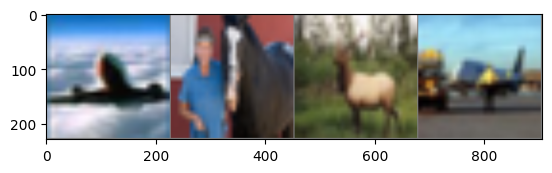

torch.Size([4, 3, 224, 224])
plane horse  deer plane


In [7]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))

print(images.size())
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [84]:
from transformers import BeitImageProcessor, BeitForImageClassification
from PIL import Image

model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k')
num_labels = 10  # For CIFAR-10
model.classifier = nn.Linear(model.config.hidden_size, num_labels)

print(model.classifier)
print(model.config.hidden_size)
# print(model)

model.to(device)  

for name, param in model.named_parameters():
    if 'beit.encoder.layer.11' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Optionally, verify which parameters are unfrozen
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Unfrozen parameter: {name}")


print(model(torch.randn(4, 3, 224, 224).to(device)))
print(model(torch.randn(4, 3, 224, 224).to(device)).logits.shape)
assert model(torch.randn(4, 3, 224, 224).to(device)).logits.shape == torch.Size([4, 10])
# print(model.classifier)


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)
768
Unfrozen parameter: beit.encoder.layer.11.lambda_1
Unfrozen parameter: beit.encoder.layer.11.lambda_2
Unfrozen parameter: beit.encoder.layer.11.attention.attention.query.weight
Unfrozen parameter: beit.encoder.layer.11.attention.attention.query.bias
Unfrozen parameter: beit.encoder.layer.11.attention.attention.key.weight
Unfrozen parameter: beit.encoder.layer.11.attention.attention.value.weight
Unfrozen parameter: beit.encoder.layer.11.attention.attention.value.bias
Unfrozen parameter: beit.encoder.layer.11.attention.output.dense.weight
Unfrozen parameter: beit.encoder.layer.11.attention.output.dense.bias
Unfrozen parameter: beit.encoder.layer.11.intermediate.dense.weight
Unfrozen parameter: beit.encoder.layer.11.intermediate.dense.bias
Unfrozen parameter: beit.encoder.layer.11.output.dense.weight
Unfrozen parameter: beit.encoder.layer.11.output.dense.bias
Unfrozen parameter: beit.encoder.layer.11.layernorm_before.weight
Unfrozen 

In [100]:
from pathlib import Path
from transformers import BeitForImageClassification

epoch_start = 0     # Start from epoch 0 or last checkpoint epoch
iter_n = len(trainloader)  # number of iteration per epoch
record_freq = 100 # how many times to record the loss and accuracy per epoch
print_freq = 100 # Print frequency, need to be multiple of record_freq.
iter_n_per_record = iter_n // record_freq  # Record frequency.
iter_n_per_print = iter_n // print_freq # Print frequency, need to be multiple of record_freq.

# a number for computing running validation loss in each iteration.
train_per_valid = len(trainloader) / len(validloader)  

avg_train_losses, avg_valid_losses = [], []   # Avg. losses.
train_accuracies, valid_accuracies = [], []  # Train and test accuracies.

model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k')
num_labels = 10  # For CIFAR-10
model.classifier = nn.Linear(model.config.hidden_size, num_labels)

# Freeze the layers except the last encoder and classifier
for name, param in model.named_parameters():
    if 'beit.encoder.layer.11' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Optionally, verify which parameters are unfrozen
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Unfrozen parameter: {name}")


# Move the network parameters to the specified device
# need to be done before passing to optimizer. 
model.to(device)  
# sanity test
assert model(torch.randn(4, 3, 224, 224).to(device)).logits.shape == torch.Size([4, 10])

# We use Adam as optimizer.
opt = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss() 

# add scheduling
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

# directory to save the model
directory_path = Path("./checkpoints/transfer_biet_encoder_lc_batch20")
# Make the directory if it doesn't exist
directory_path.mkdir(parents=True, exist_ok=True)


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfrozen parameter: beit.encoder.layer.11.lambda_1
Unfrozen parameter: beit.encoder.layer.11.lambda_2
Unfrozen parameter: beit.encoder.layer.11.attention.attention.query.weight
Unfrozen parameter: beit.encoder.layer.11.attention.attention.query.bias
Unfrozen parameter: beit.encoder.layer.11.attention.attention.key.weight
Unfrozen parameter: beit.encoder.layer.11.attention.attention.value.weight
Unfrozen parameter: beit.encoder.layer.11.attention.attention.value.bias
Unfrozen parameter: beit.encoder.layer.11.attention.output.dense.weight
Unfrozen parameter: beit.encoder.layer.11.attention.output.dense.bias
Unfrozen parameter: beit.encoder.layer.11.intermediate.dense.weight
Unfrozen parameter: beit.encoder.layer.11.intermediate.dense.bias
Unfrozen parameter: beit.encoder.layer.11.output.dense.weight
Unfrozen parameter: beit.encoder.layer.11.output.dense.bias
Unfrozen parameter: beit.encoder.layer.11.layernorm_before.weight
Unfrozen parameter: beit.encoder.layer.11.layernorm_before.bias
U

In [101]:
print(train_per_valid)

7.0


In [102]:
import re

# Pattern to match the files and extract epoch numbers
pattern = r'epoch_(\d+).pth'

# Use Path.glob to list all files matching the pattern
files = list(directory_path.glob('epoch_*.pth'))

# Extract epochs and files into a list of tuples
epoch_files = []
for file_path in files:
    match = re.search(pattern, file_path.name)
    if match:
        epoch_num = int(match.group(1))
        epoch_files.append((epoch_num, file_path))

# Sort the list by epoch number in descending order
epoch_files.sort(key=lambda x: x[0], reverse=False)

if epoch_files:
    # populating history for loss and accuracy for plotting
    for file in epoch_files:
        checkpoint = torch.load(file[1])
        avg_train_losses += checkpoint['avg_train_losses']
        avg_valid_losses += checkpoint['avg_valid_losses']
        train_accuracies.append(checkpoint['train_accuracy'])
        valid_accuracies.append(checkpoint['valid_accuracy'])
    
    # load the model from the latest checkpoint file
    latest_file_path = epoch_files[-1][1]
    print(f"The latest checkpoint file is: {latest_file_path}")
    checkpoint = torch.load(latest_file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    # start training from the next epoch
    epoch_start = checkpoint['epoch'] + 1
else:
    print("No checkpoint files found.")
        

The latest checkpoint file is: models/transfer_biet_encoder_lc_batch20/epoch_0000.pth


In [103]:
epochs = 4  # Total epochs.

for epoch in range(epoch_start, epoch_start + epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    running_val_loss = 0.0     # Initialize running train_loss for validation set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    valid_total = 0   
    valid_correct = 0
    
    print('--> [Start of epoch {}]'.format(epoch) +
          '  lr: {:.6f}'.format(scheduler.get_last_lr()[0]))
    
    # print('--> [Start of epoch {}]'.format(epoch))
    
    validiter = iter(validloader)
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Set the model to training mode.
        model.train()
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = model(inputs).logits
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        model.eval()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, train_predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()
        
        # only iterate through validation set according to train_per_valid ratio
        if i % train_per_valid == train_per_valid - 1:
            # Set the model to evaluation mode.
            with torch.no_grad():
                valid_inputs, valid_labels = next(validiter)
                valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
                valid_output = model(valid_inputs).logits
                valid_loss = loss_func(valid_output, valid_labels)
                running_val_loss += valid_loss.item()
                
                _, valid_predicted = torch.max(valid_output.data, 1)
                valid_total += valid_labels.size(0)
                valid_correct += (valid_predicted == valid_labels).sum().item()
            
        # Record training/validation loss every several mini-batches.
        if i % iter_n_per_record == iter_n_per_record - 1: 
            avg_train_loss = running_train_loss / iter_n_per_record
            avg_train_losses.append(avg_train_loss)
            avg_valid_loss = train_per_valid * running_val_loss / iter_n_per_record
            avg_valid_losses.append(avg_valid_loss)
            running_train_loss, running_val_loss = 0.0, 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % iter_n_per_print == iter_n_per_print - 1:
                print('[epoch: {}, i: {:5d}]'.format(epoch, i) +
                      '  train_loss: {:.3f}'.format(avg_train_loss) + 
                      '  |  valid_loss: {:.3f}'.format(avg_valid_loss))
                            

    # exponential scheduling
    scheduler.step()
                   
    # calculating train accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    valid_accuracy = 100 * valid_correct / valid_total
    valid_accuracies.append(valid_accuracy)     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    file_name = f'epoch_{epoch:04d}.pth'
    save_path = directory_path / file_name
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'avg_train_losses': avg_train_losses[epoch * iter_n_per_record : (epoch + 1) * iter_n_per_record],
            'avg_valid_losses': avg_valid_losses[epoch * iter_n_per_record : (epoch + 1) * iter_n_per_record],
            'train_accuracy': train_accuracies[epoch],
            'valid_accuracy': valid_accuracies[epoch],
            }, save_path)
    
    print('--> [End of epoch {}]'.format(epoch) +
                      ' train_accuracy: {:.2f}%'.format(train_accuracy) + 
                      '  |  valid_accuracy: {:.2f}%'.format(valid_accuracy))

print('Finished Training.')

--> [Start of epoch 1]  lr: 0.000450
[epoch: 1, i:    34]  train_loss: 0.823  |  valid_loss: 0.742
[epoch: 1, i:    69]  train_loss: 0.867  |  valid_loss: 0.999
[epoch: 1, i:   104]  train_loss: 0.872  |  valid_loss: 0.886
[epoch: 1, i:   139]  train_loss: 0.823  |  valid_loss: 1.021
[epoch: 1, i:   174]  train_loss: 0.856  |  valid_loss: 0.891
[epoch: 1, i:   209]  train_loss: 0.761  |  valid_loss: 0.525
[epoch: 1, i:   244]  train_loss: 0.888  |  valid_loss: 0.944
[epoch: 1, i:   279]  train_loss: 0.809  |  valid_loss: 0.937


KeyboardInterrupt: 

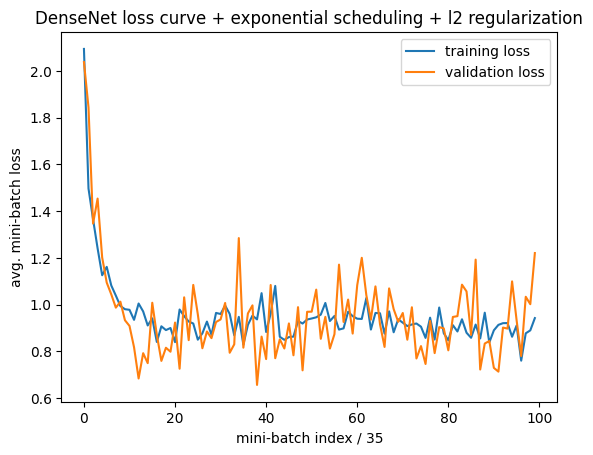

In [99]:
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('DenseNet loss curve + exponential scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(iter_n_per_record))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [ ]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.title('DenseMax accuracy curve for exponential scheduling + l2 regularization')
plt.xlabel('epoch / {}'.format(iter_n_per_record))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

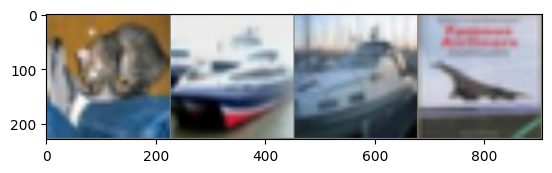

GroundTruth:    cat  ship  ship plane
tensor([[-4.1969, -4.9523, -2.5574,  0.2061, -3.3296, -1.0196, -2.8795, -2.4233,
         -4.4739, -5.7947],
        [ 1.1192,  3.8116, -3.5688, -4.6224, -5.4832, -8.5623, -7.3179, -4.3186,
          4.3057,  0.1889],
        [-1.7430, -0.8710, -3.4608, -2.8184, -3.9551, -5.3261, -8.8907, -3.3871,
          4.0609, -0.3079],
        [-0.4319, -3.2233, -0.6971, -1.5317, -2.2743, -5.6757, -7.3389, -4.2840,
          2.6572, -3.7655]], device='mps:0')
tensor([0.2061, 4.3057, 4.0609, 2.6572], device='mps:0')
Predicted:    cat  ship  ship  ship


In [71]:
# Check several images.
dataiter = iter(validloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = model(images.to(device)).logits

print(outputs.data)
# max compare along the row, returns a tuple (max value, index of the max value)
# index is the predicted class label
# alternatively can just use outputs.data.argmax(-1) that only returns the index
_, predicted = torch.max(outputs.data, -1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [72]:
model.to(device)
model.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

KeyboardInterrupt: 

In [53]:
model.to(device)
model.eval()

# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 88 %
Accuracy of  bird : 65 %
Accuracy of   cat : 65 %
Accuracy of  deer : 70 %
Accuracy of   dog : 55 %
Accuracy of  frog : 77 %
Accuracy of horse : 73 %
Accuracy of  ship : 84 %
Accuracy of truck : 76 %
